In [1]:
import os
import math
import random
import itertools
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import networkx as nx
from joblib import Parallel, delayed

import powerlaw

from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector

random.seed(133)
np.random.seed(133)


### Recycling Model Initialization

Define agents, set parameters, build network and grid, initialize data collection.


In [2]:
# utility functions

def weighted_average(history, decay=0.8):
    # exponentially weighted average of time series
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)

def compute_avalanches(series, delta=0.01):
    # compute avalanche sizes based on large jumps
    return np.diff(series)[np.diff(series) > delta]

# household agent 
class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        # household with recycling preference P and cost C0
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5 
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0


    def step(self):
        # update perceived rho and deltaC through weighted memory
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        

        # compute utilities and update strategy
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        # update neighborhood rho and contribute to bin in case of recycling
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)

# bin agent 
class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        # initialize bin with capacity K_m at location pos
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos
    def step(self): pass
    def advance(self): pass

# recycling model 
class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, k=4, beta=0.1, delta=0.5, c=0.3, kappa=0.05,
                 epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                 logit=False, lambda_param=1.0, seed=133, activation='random', decay=0.8):
        super().__init__()
        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        
        # store parameters
        self.num_agents, self.grid_size, self.num_bins = N, L, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay


        # create network 
        self.G = nx.watts_strogatz_graph(n=N, k=k, p=beta, seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.grid = MultiGrid(width=L, height=L, torus=False)
        self.schedule = SimultaneousActivation(self)

        # add bins at specific positions
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in [2, 5, 8] for y in [2, 5, 8]]
        for m, (x_m, y_m) in enumerate(bin_positions):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        # assign agents to grid and assign preferences
        coords = [(i, j) for i in range(L) for j in range(L)][:N]
        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0  # high P to champions

        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)


        # initialize social influence variables
        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0


        # setup data collection
        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m)
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        # reset bin loads
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        # compute overload cost for each household
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)


### Fit Avalanche Distribution

Run avalanche analysis on ER networks, fit power-law and truncated power-law models, compute statistics, plot CCDF.


Assuming nested distributions


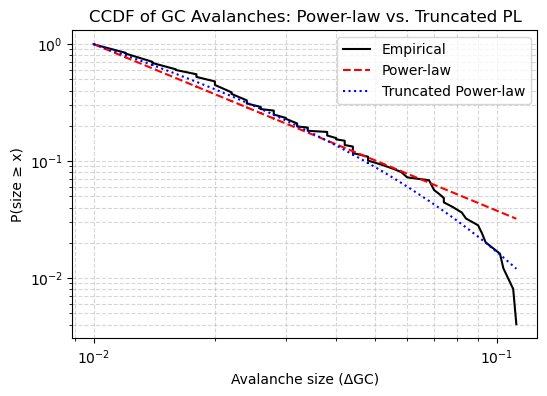

{'power_law': {'model': 'power_law',
  'alpha': 2.4232309603085493,
  'xmin': 0.01,
  'ks': 0.119219534915534},
 'truncated_power_law': {'model': 'truncated_power_law',
  'alpha': 1.8005019493297139,
  'lambda': 14.95665836674133,
  'xmin': 0.01,
  'ks': 0.0766727468464144},
 'comparison': {'R_ln': -3.337236353111802,
  'p_ln': 0.10591311990778847,
  'R_exp': 13.430158563390176,
  'p_exp': 0.09052006783286282,
  'R_tpl': -5.231109181362753,
  'p_tpl': 0.0012184087424454981}}

In [3]:
N = 500  # number of nodes
num_trials = 10  # number of random trials
p_vals = np.linspace(0.0005, 0.005, 200)  # range of connection probabilities

# trial function
def compute_gc_series_trial(N, p_vals, seed=None):
    # simulate GC size across p_vals
    rng = np.random.default_rng(seed)
    gc_series = []
    for p in p_vals:
        G = nx.erdos_renyi_graph(N, p, seed=int(seed) % (2**32))
        if len(G) == 0 or not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1:
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# run multiple trials
all_gc_series = Parallel(n_jobs=-1)(
    delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
)


# get avalanche sizes
all_avalanches = []
for series in all_gc_series:
    aval = np.diff(series)
    aval = aval[aval > 0.01]  # filter meaningful changes
    all_avalanches.extend(aval)

# fit distributions and plot
results = {}
if len(all_avalanches) >= 5:
    fit = powerlaw.Fit(all_avalanches, xmin=0.01, discrete=False)

    # fit power-law
    results['power_law'] = {
        "model": "power_law",
        "alpha": fit.power_law.alpha,
        "xmin": fit.power_law.xmin,
        "ks": fit.power_law.KS()
    }


    # fit truncated power-law
    results['truncated_power_law'] = {
        "model": "truncated_power_law",
        "alpha": fit.truncated_power_law.alpha,
        "lambda": fit.truncated_power_law.parameter2,
        "xmin": fit.truncated_power_law.xmin,
        "ks": fit.truncated_power_law.KS()
    }

    # Ccompare with other distributions
    R_ln, p_ln = fit.distribution_compare('power_law', 'lognormal')
    R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
    R_tpl, p_tpl = fit.distribution_compare('power_law', 'truncated_power_law')

    results['comparison'] = {
        "R_ln": R_ln, "p_ln": p_ln,
        "R_exp": R_exp, "p_exp": p_exp,
        "R_tpl": R_tpl, "p_tpl": p_tpl
    }

    # plot CCDF
    fig, ax = plt.subplots(figsize=(6, 4))
    fit.plot_ccdf(ax=ax, label='Empirical', color='black')
    fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label='Power-law')
    fit.truncated_power_law.plot_ccdf(ax=ax, color='blue', linestyle=':', label='Truncated Power-law')
    plt.xlabel("Avalanche size (ΔGC)")
    plt.ylabel("P(size ≥ x)")
    plt.title("CCDF of GC Avalanches: Power-law vs. Truncated PL")
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/er_gc_avalanches_powerlaw_parallel.png", dpi=300)
    plt.show()


results


### CCDF Comparison Across Network Sizes

Run avalanche experiments for varying network sizes and connection sampling steps. Fit power-law distributions and record KS statistics and exponents. Plot CCDFs.


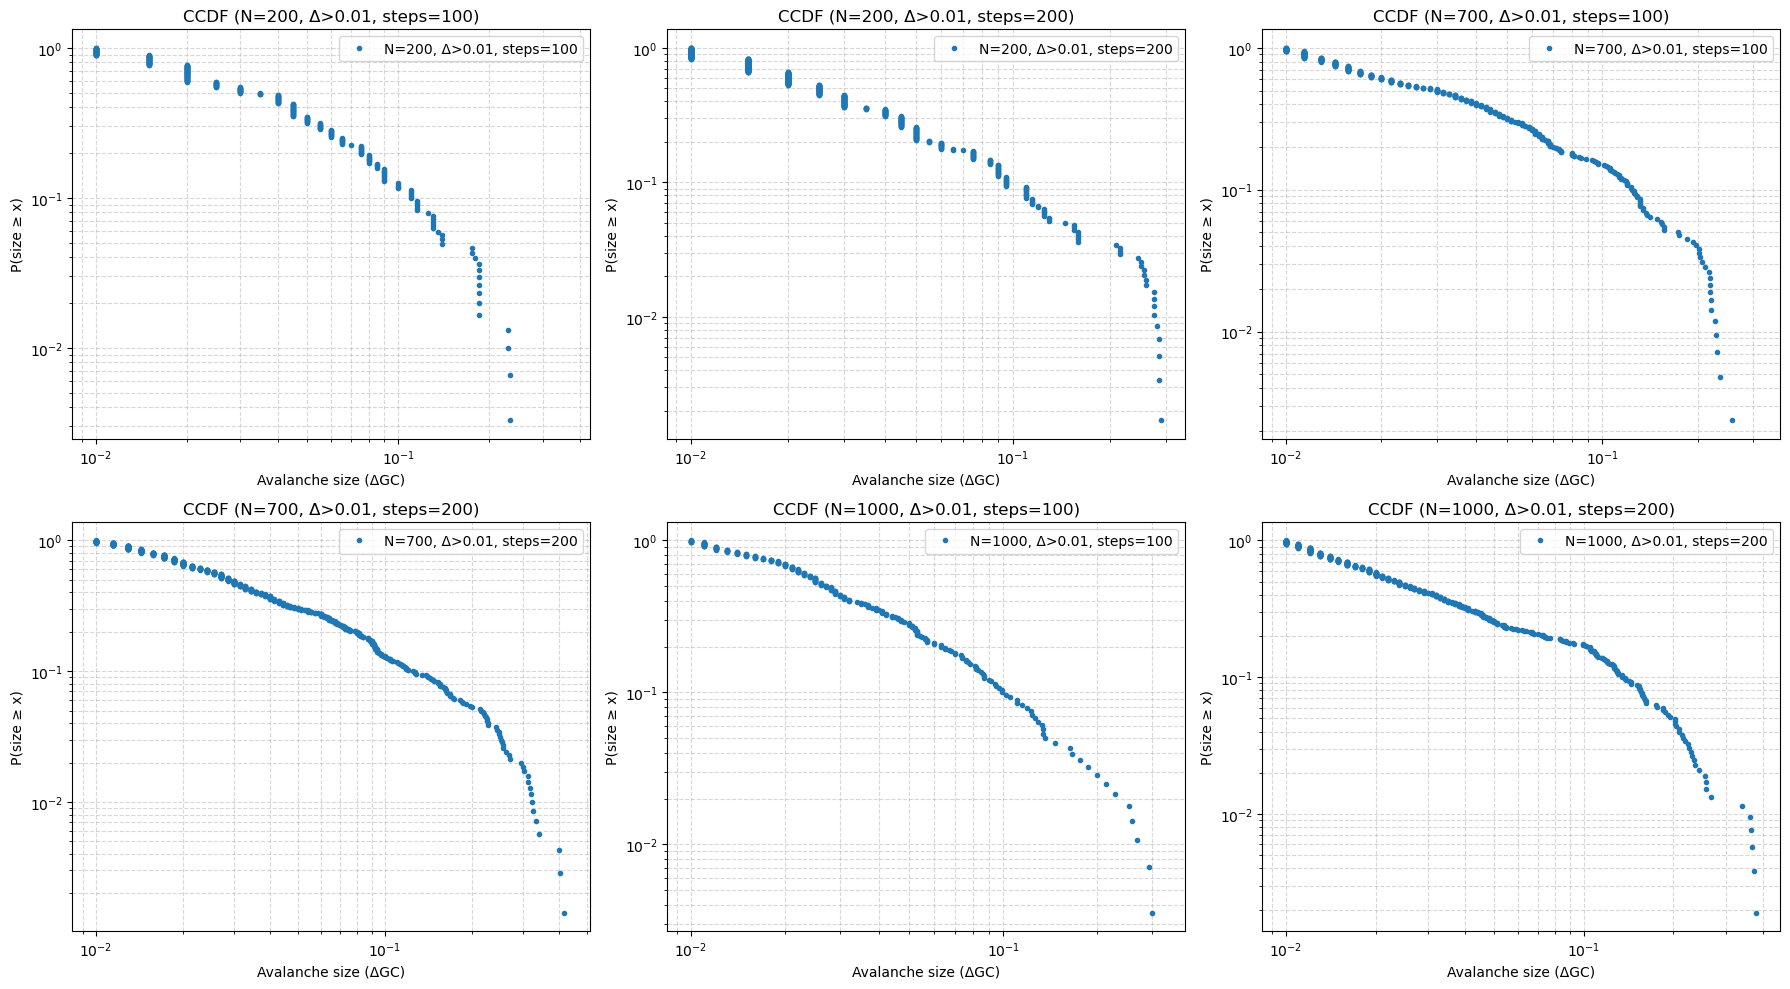

,N,Delta,P steps,KS statistic,Alpha
0,200,0.01,100,0.195527,1.802262
1,200,0.01,200,0.149734,1.948460
2,700,0.01,100,0.116308,1.844119
3,700,0.01,200,0.129536,1.806074
4,1000,0.01,100,0.154058,1.863487
5,1000,0.01,200,0.056769,1.897024


In [4]:
os.makedirs("figures", exist_ok=True)


Ns = [200, 700, 1000]
deltas = [0.01]
p_granularities = [100, 200]
num_trials = 10
p_range = (0.0005, 0.005)


# compute GC series
def compute_gc_series_trial(N, p_vals, seed):
    gc_series = []
    for i, p in enumerate(p_vals):
        G = nx.erdos_renyi_graph(N, p, seed=seed + i)
        if len(G) == 0 or (not nx.is_connected(G) and len(max(nx.connected_components(G), key=len)) == 1):
            gc_frac = 0.0
        else:
            gc_frac = len(max(nx.connected_components(G), key=len)) / N
        gc_series.append(gc_frac)
    return gc_series

# run GC and avalanche detection
def run_er_experiment(N, delta, p_steps):
    p_vals = np.linspace(*p_range, p_steps)
    all_gc_series = Parallel(n_jobs=-1)(
        delayed(compute_gc_series_trial)(N, p_vals, seed=i) for i in range(num_trials)
    )
    all_avalanches = []
    for series in all_gc_series:
        aval = np.diff(series)
        aval = aval[aval > delta] 
        all_avalanches.extend(aval)
    return all_avalanches

# log-log CCDF plotting 
def plot_ccdf(data, ax, label):
    sorted_data = np.sort(data)
    ccdf = 1.0 - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    ax.plot(sorted_data, ccdf, marker='.', linestyle='none', label=label)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Avalanche size (ΔGC)")
    ax.set_ylabel("P(size ≥ x)")
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.legend()



param_combinations = list(itertools.product(Ns, deltas, p_granularities))
n_cols = 3
n_rows = math.ceil(len(param_combinations) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()
summary_rows = []

# run simulations, fit power law, collect stats, plot
for i, (N, delta, p_steps) in enumerate(param_combinations):
    avalanches = run_er_experiment(N, delta=delta, p_steps=p_steps)

    if len(avalanches) >= 5:
        fit = powerlaw.Fit(avalanches, xmin=delta, discrete=False, verbose=False)
        ks_stat = fit.power_law.KS()
        alpha = fit.power_law.alpha
        summary_rows.append({
            "N": N,
            "Delta": delta,
            "P steps": p_steps,
            "KS statistic": ks_stat,
            "Alpha": alpha
        })

    ax = axs[i]
    label = f"N={N}, Δ>{delta}, steps={p_steps}"
    plot_ccdf(avalanches, ax, label=label)
    ax.set_title(f"CCDF (N={N}, Δ>{delta}, steps={p_steps})")

# remove any unused axes from the subplot grid
for j in range(len(param_combinations), len(axs)):
    fig.delaxes(axs[j])



# finalize
plt.tight_layout()
plt.savefig("figures/er_avalanches_ccdf_all.png", dpi=300)
plt.show()

summary_df = pd.DataFrame(summary_rows)
summary_df
